In [35]:
import urllib.request
import zipfile
# ZIP data URL from GitHub
zip_url = "https://github.com/pandadev-xv/dl-exam-0620/raw/main/input_data.zip"
# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)
# Unzip the folder
target_folder = "temp"
# reading data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"
#Then use the following lines to read it:
import pickle as pk
with open(data_path, 'rb') as f:
  data = pk.load(f)
images = data['imgs']
y = data['labels']
labels = y[:,0]
bboxes = y[:,1:]

(186, 227, 227, 3)


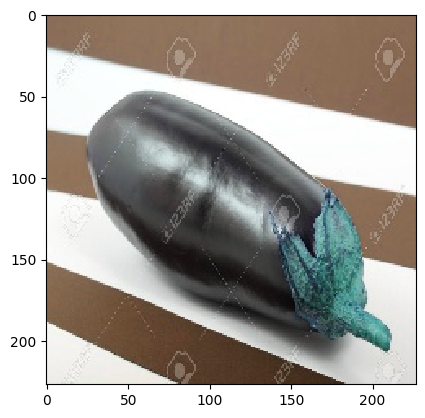

In [36]:
from matplotlib import pyplot as plt
import numpy as np
def show_img(data):
    plt.imshow(data.astype('uint8'), interpolation='nearest')
    plt.show()

print(images.shape)
show_img(images[np.random.randint(0, 186)])

# Exam 06/20 - Deep Learning - Andrea Pan
In this notebook we design a model to recognize 3 different classes of images, as well as retrieve the four coordinates of our image bounding box for the object.

# Preprocessing
We apply normalization of RGB values of our images. Instead of a value in [0, 255], we have instead a float in [0, 1].

In [37]:
images = images.astype('float32') / 255.0
labels = labels.astype('int32') - 1
bboxes = bboxes.astype('float32') / 227.0

In [38]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
train_bboxes, test_bboxes = train_test_split(bboxes, test_size=0.2, random_state=42)

In [39]:
num_classes = len(np.unique(labels))
print(num_classes)

3


In [40]:
# def check_inputs(inputs):
#     print("Shape:", inputs.shape)
#     print("Type:", inputs.dtype)
#     return inputs


# check_inputs(train_bboxes)
# check_inputs(train_images)

In [41]:
import tensorflow as tf
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.models import Model

inputs = tf.keras.Input(shape=(227, 227, 3))

x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)

class_out = Dense(3, activation='softmax', name='class_out')(x)
bbox_out = Dense(4, activation='sigmoid', name='bbox_out')(x)

model = Model(inputs=inputs, outputs=[class_out, bbox_out])

model.compile(optimizer='adam',
              loss={
                  'class_out': 'categorical_crossentropy',
                  'bbox_out': 'mse'
              },
              metrics={
                  'class_out': 'accuracy',
                  'bbox_out': 'mse'
              },
              run_eagerly=True)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 227, 227, 3)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 225, 225, 32)         896       ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 112, 112, 32)         0         ['conv2d_9[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 110, 110, 64)         18496     ['max_pooling2d_9[0][0]'

In [43]:
history = model.fit(
    train_images,
    [tf.keras.utils.to_categorical(train_labels, num_classes=num_classes), train_bboxes],
    epochs=300,
    validation_data=(test_images, [tf.keras.utils.to_categorical(test_labels, num_classes=num_classes), test_bboxes]),
    batch_size=32
    )

Epoch 1/300
5/5 [==============================] - 1s 166ms/step - loss: 0.0347 - class_out_loss: 0.0328 - bbox_out_loss: 0.0019 - class_out_accuracy: 0.9797 - bbox_out_mse: 0.0019 - val_loss: 0.3628 - val_class_out_loss: 0.3568 - val_bbox_out_loss: 0.0061 - val_class_out_accuracy: 0.9333 - val_bbox_out_mse: 0.0061
Epoch 2/300
5/5 [==============================] - 1s 133ms/step - loss: 0.5819 - class_out_loss: 0.5689 - bbox_out_loss: 0.0130 - class_out_accuracy: 0.8581 - bbox_out_mse: 0.0130 - val_loss: 0.0767 - val_class_out_loss: 0.0667 - val_bbox_out_loss: 0.0100 - val_class_out_accuracy: 1.0000 - val_bbox_out_mse: 0.0100
Epoch 3/300
5/5 [==============================] - 1s 128ms/step - loss: 0.2738 - class_out_loss: 0.2593 - bbox_out_loss: 0.0145 - class_out_accuracy: 0.8851 - bbox_out_mse: 0.0145 - val_loss: 0.3462 - val_class_out_loss: 0.3316 - val_bbox_out_loss: 0.0145 - val_class_out_accuracy: 0.8667 - val_bbox_out_mse: 0.0145
Epoch 4/300
5/5 [==============================] 

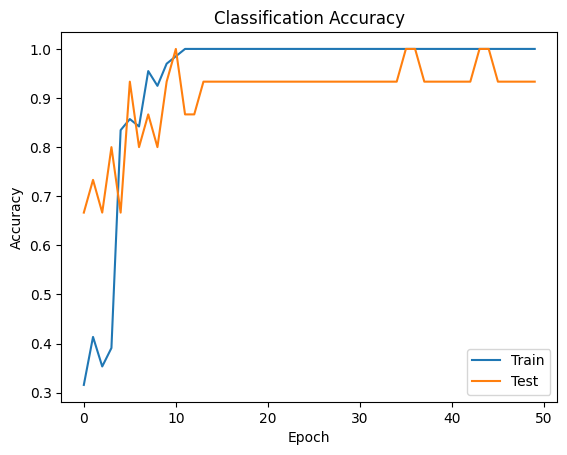

In [44]:
# Plot training & validation accuracy values
plt.plot(history_train.history['class_out_accuracy'])
plt.plot(history_train.history['val_class_out_accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

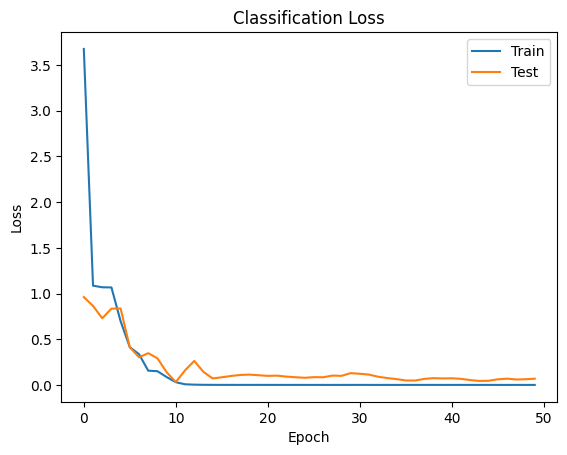

In [45]:
# Plot training & validation accuracy values
plt.plot(history_train.history['class_out_loss'])
plt.plot(history_train.history['val_class_out_loss'])
plt.title('Classification Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

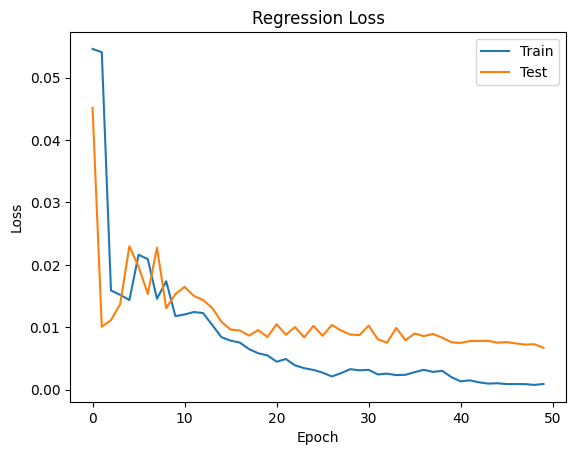

In [46]:
# Plot training & validation accuracy values
plt.plot(history_train.history['bbox_out_loss'])
plt.plot(history_train.history['val_bbox_out_loss'])
plt.title('Regression Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()